# Visualization of the chemical space using Ersilia Compound Embeddings

In [40]:
from eosce import ErsiliaCompoundEmbeddings
import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import stylia
from sklearn.decomposition import PCA

df = pd.read_csv('../data/data_0.csv')

In [16]:
inchikeys_list = df['InchiKey'].tolist()
smiles_list = df['Smiles'].tolist()
embedder = ErsiliaCompoundEmbeddings()
X = embedder.transform(smiles_list)
embeddings_file = '../data/ersilia_embeddings.npy'
with open(embeddings_file, 'wb') as f:
    np.save(f, X)

In [52]:
reducer_0 = PCA(n_components=0.9)
P_0 = reducer_0.fit_transform(X)

reducer_1 = UMAP(n_components=2)
P = reducer_1.fit_transform(P_0)

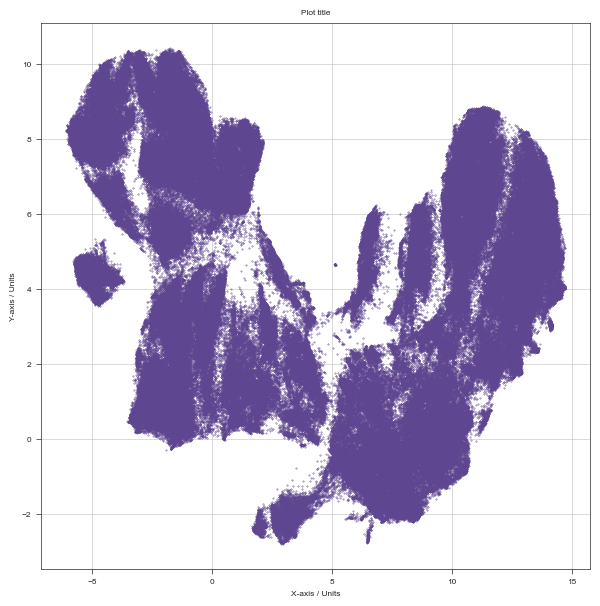

In [56]:
dc = pd.read_csv('../data/eosi_s4_candidates_90.csv')

In [58]:
Xc = embedder.transform(dc['Smiles'].tolist())
Pc = reducer_1.transform(reducer_0.transform(Xc))

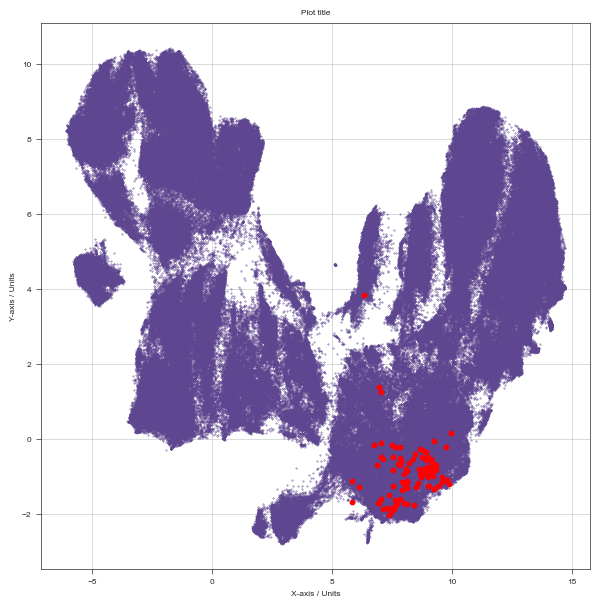

In [60]:
fig, axs = stylia.create_figure(1,1, height=stylia.TWO_COLUMNS_WIDTH, width=stylia.TWO_COLUMNS_WIDTH)
ax = axs.next()
ax.scatter(P[:,0], P[:,1], s=0.1)
ax.scatter(Pc[:,0], Pc[:,1], s=10, c='r')

In [ ]:
from stylia.colors.colors import NamedColors

named_colors = NamedColors()

def get_idxs_from_inchikeys(inchikeys, inchikeys_list):
    idxs = []
    for inchikey in inchikeys:
        idxs.append(inchikeys_list.index(inchikey))
    return idxs

def projection_plot(ax, P, idxs, colors):
    ax.scatter(P[:,0], P[:,1], s=0.1, color=named_colors.grey)
    ax.scatter(P[idxs,0], P[idxs,1], s=10, c=colors)
    ax.hide_axes()
    return ax

fig, axs = stylia.create_figure(1, 7, height=stylia.TWO_COLUMNS_WIDTH*0.2, width=stylia.TWO_COLUMNS_WIDTH*0.7)
ax = axs.next()

# all compounds
projection_plot(ax, P, P)

# desired physchem properties
ax = axs.next()
dc = pd.read_csv('../data/data_2.csv')
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

# desired synthetic accessibility
ax = axs.next()
dc = pd.read_csv("../data/data_3.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

# predicted high activity
ax = axs.next()
dc = pd.read_csv("../data/data_6.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

# eliminate scaffold redundancy
ax = axs.next()
dc = pd.read_csv("../data/data_7.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

# selection by activity of other models
ax = axs.next()
dc = pd.read_csv("../data/data_13.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

# final selection of 90 compounds
ax = axs.next()
dc = pd.read_csv("../data/eosi_s4_candidates_90.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, )

plt.tight_layout()
stylia.save_figure("../assets/projections_plots.png")

In [20]:
import pandas as pd



In [33]:
import matplotlib.pyplot as plt

df = pd.read_csv('../data/data_13.csv')

fig, axs = stylia.create_figure(1,1, height=stylia.TWO_COLUMNS_WIDTH, width=stylia.TWO_COLUMNS_WIDTH)
ax = axs.next()
ax.hist(df["MolWt"], color=named_colors.blue)
ax.set_xlabel("Molecular weight")
ax.set_ylabel("Frequency")
plt.tight_layout()

stylia.save_figure("../assets/molecular_weight_histogram.png")

NameError: name 'stylia' is not defined

([<matplotlib.patches.Wedge at 0x15265e3b0>,
 [Text(6.735557395310444e-17, 1.1, ''),
  Text(-2.0206672185931328e-16, -1.1, '')])

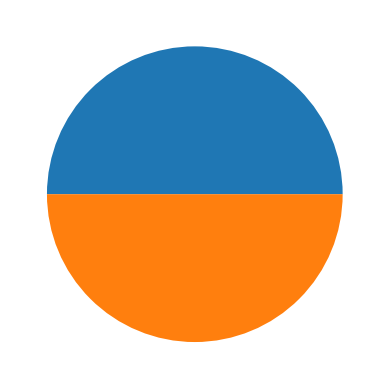

In [34]:
fig, axs = stylia.create_figure(2,3, height=stylia.TWO_COLUMNS_WIDTH, width=stylia.TWO_COLUMNS_WIDTH)

def pie_chart(ax, df, column):
    x = df[column]
    n = np.sum(x)
    N = len(x)
    ax.pie([n, N-n])

columns = [
    ["TriazoloPhenyl"],
    ["TriazoloHeteroarylPara", "TriazoloHeteroarylMeta", "TriazoloHeteroarylOrto"],
    ["PyrazineEther", "PyrazineAmide"],
]

In [31]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsTriazoloPyrazine,556.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroaryl,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloPhenyl,556.0,0.821942,0.382906,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylPara,556.0,0.776978,0.416648,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylMeta,556.0,0.275180,0.447007,0.000000,0.000000,0.000000,1.000000,1.000000
TriazoloHeteroarylOrto,556.0,0.109712,0.312812,0.000000,0.000000,0.000000,0.000000,1.000000
TriazoloNaphthalene,556.0,0.001799,0.042409,0.000000,0.000000,0.000000,0.000000,1.000000
PyrazineEther,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
PyrazineAmide,556.0,0.032374,0.177151,0.000000,0.000000,0.000000,0.000000,1.000000
MolWt,556.0,457.088567,25.817924,380.398000,440.370750,457.409000,476.463500,531.466000
